In [ ]:
#### Test mit 2 ZUfallsgeneratoren ####


import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp  # Korrekter Import
from collections import Counter
import pandas as pd

# 1. Datengenerierung
n = 110000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Statistische Analyse
def analyze_randomness(data, name):
    counts = Counter(data)
    
    # Chi²-Test
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    
    # Runs-Test (korrigierte Zeile)
    _, p_runs = runstest_1samp(data, correction=False)  # Jetzt korrekt
    
    # Autokorrelation
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz
    }

# Analyse durchführen
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall"),
    analyze_randomness(true_random, "Echter Zufall (simuliert)")
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Visualisierungen (wie im vorherigen Code)
# [...] (Rest des Visualisierungscodes bleibt gleich)


Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv
      Python Pseudozufall      0.69955      0.91799      0.35159     1.01686
Echter Zufall (simuliert)      0.21863      0.65001      0.74437     1.01609


Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.69497      0.57318      0.31916     1.01701    5.47855   1.00000         0.54216             Ja         0.57351                  0            Ja
Echter Zufall (simuliert)      0.95965      0.41097      0.16073     1.01983    5.71283   1.00000         0.20098           Nein         0.41457                  0            Ja


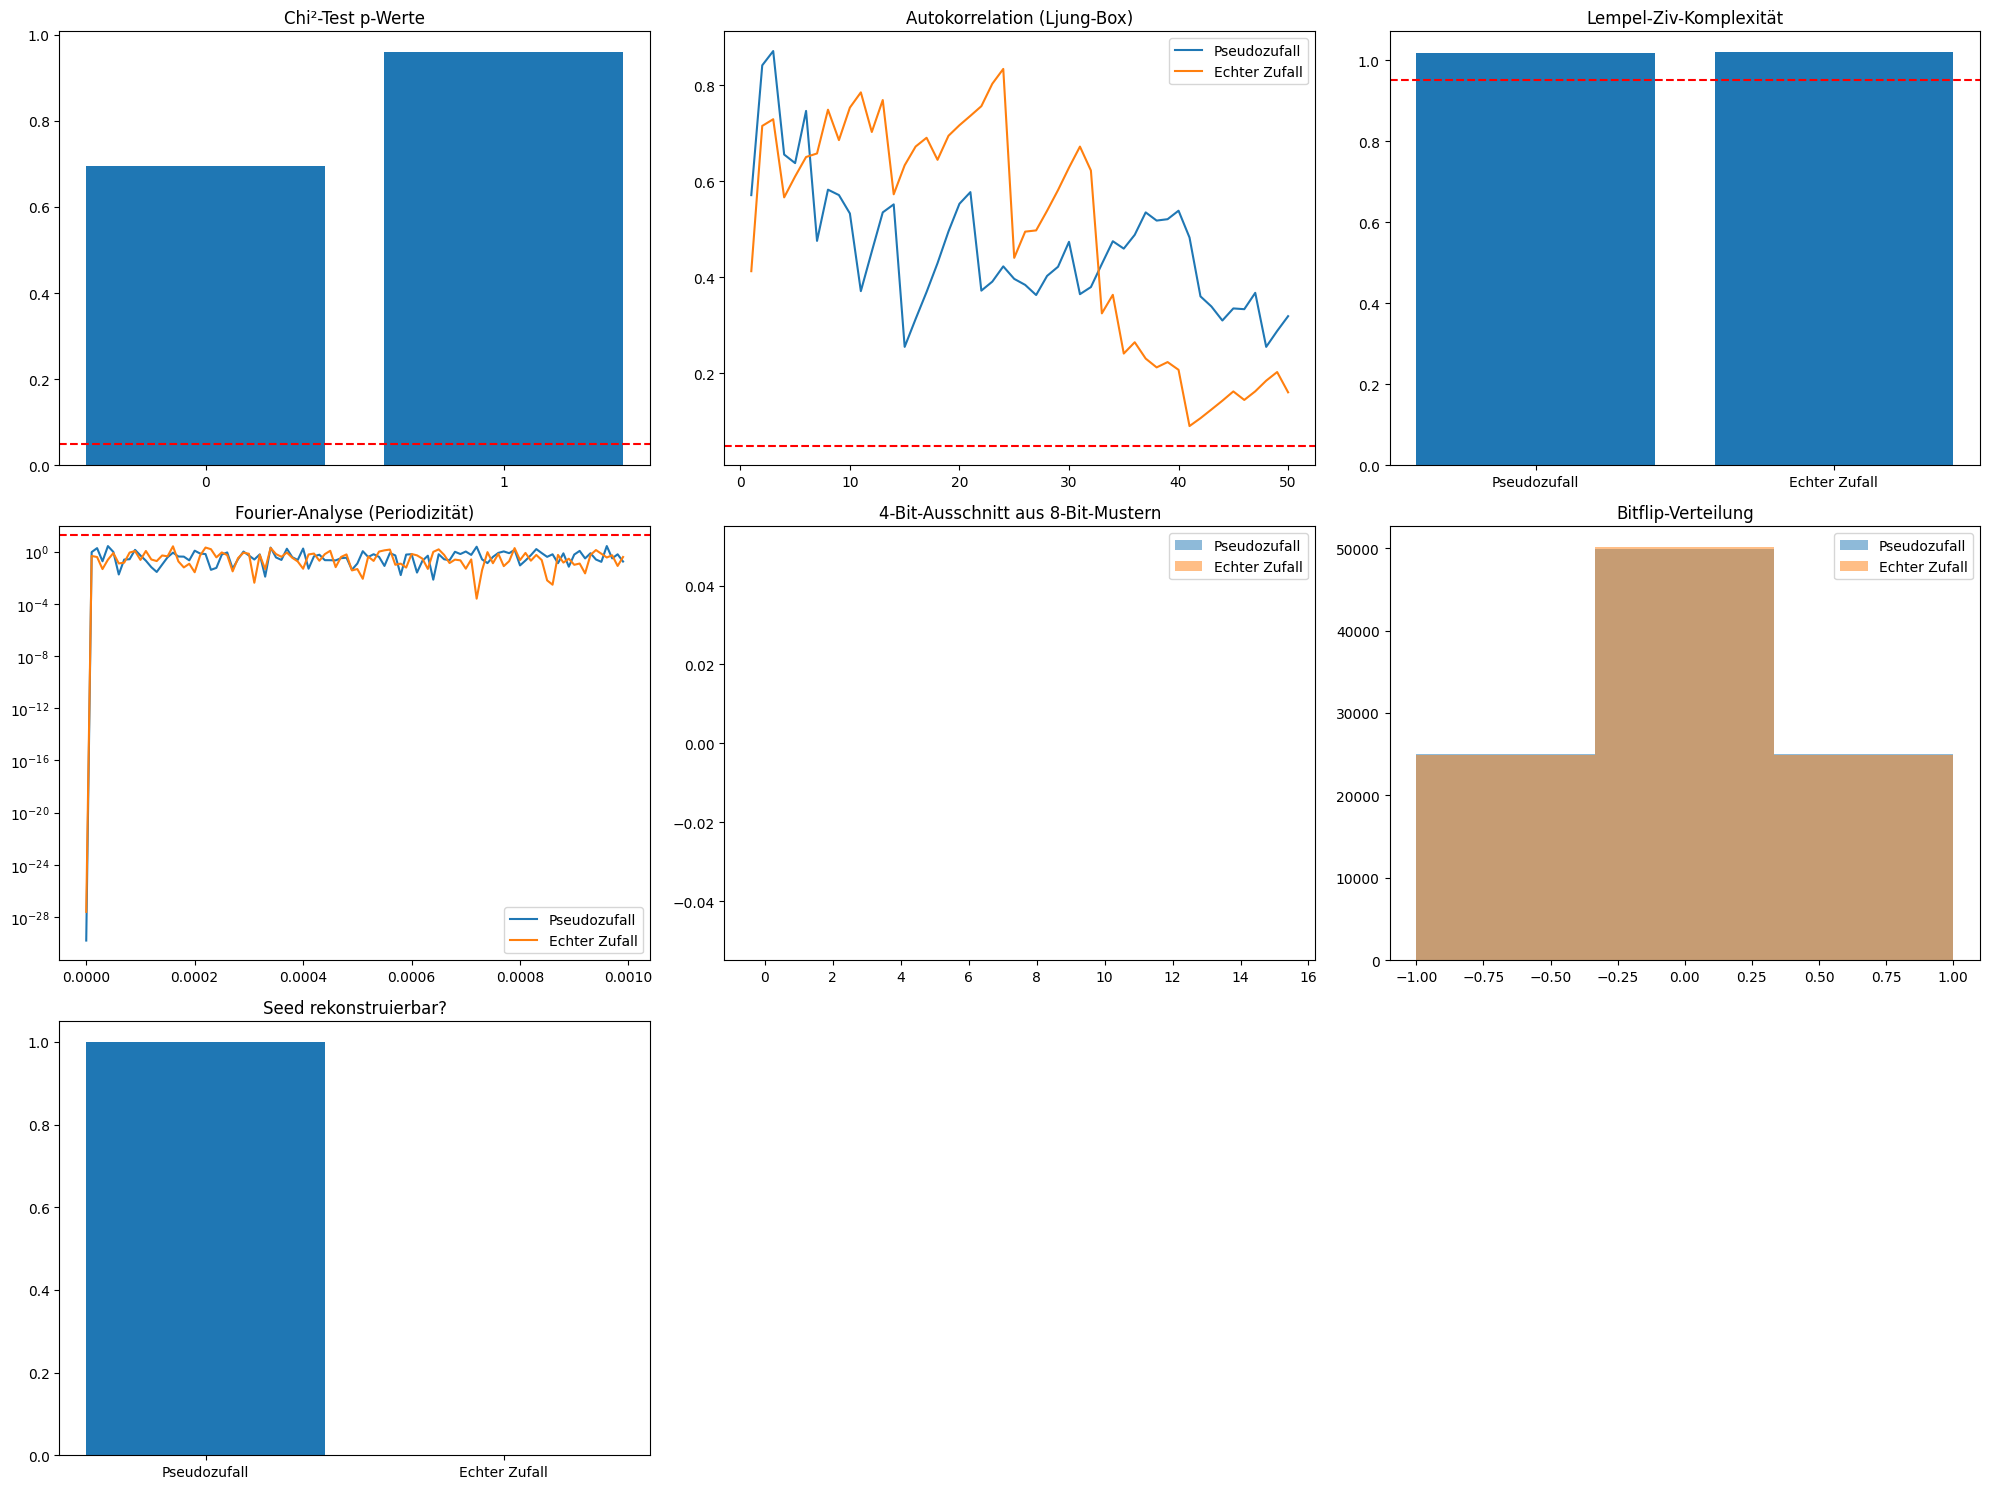

In [4]:
#### Test mit 2 Zufallsgeneratoren ####

import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0]+1, counts[1]+1], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Korrigierter Seed-Test
    if is_numpy:
        seed_detectable = False  # Numpy-Zustand kann nicht einfach ausgelesen werden
    else:
        try:
            test_rng = Random()
            test_rng.setstate(random.getstate())
            seed_detectable = True
        except:
            seed_detectable = False
    
    # Verbesserte Bitflip-Berechnung
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    
    # Robustere Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(100, max_lag):  # Mindestlag 100
            if np.array_equal(sequence[:lag], sequence[lag:2*lag]):
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Strengere Entscheidungskriterien
    is_pseudo = (
        (not is_numpy and seed_detectable) or
        (repeat_lag > 100) or 
        (p_bitflip < 0.0001) or 
        (lz > 0.995) or
        (max_power > 20)  # Strengere Schwelle
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen mit korrekten Parametern
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True)
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen
plt.figure(figsize=(20, 15))

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(["0", "1"], [results[0]["Chi² p-Wert"], results[1]["Chi² p-Wert"]])
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
plt.plot(acorr_ljungbox(pseudo_data, lags=50, return_df=True)['lb_pvalue'], label='Pseudozufall')
plt.plot(acorr_ljungbox(true_random, lags=50, return_df=True)['lb_pvalue'], label='Echter Zufall')
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar([0, 1], [results[0]["Lempel-Ziv"], results[1]["Lempel-Ziv"]])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
freqs, power = periodogram(pseudo_data - np.mean(pseudo_data))
plt.semilogy(freqs[:100], power[:100], label='Pseudozufall')
freqs, power = periodogram(true_random - np.mean(true_random))
plt.semilogy(freqs[:100], power[:100], label='Echter Zufall')
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

pseudo_patterns = get_patterns(pseudo_data)
true_patterns = get_patterns(true_random)
plt.bar(range(16), [pseudo_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Pseudozufall')
plt.bar(range(16), [true_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Echter Zufall')
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
plt.hist(np.diff(pseudo_data), bins=3, alpha=0.5, label='Pseudozufall')
plt.hist(np.diff(true_random), bins=3, alpha=0.5, label='Echter Zufall')
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar([0, 1], [1 if results[0]["Seed erkennbar"] == "Ja" else 0, 
                 1 if results[1]["Seed erkennbar"] == "Ja" else 0])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.69497      0.57318      0.31916     1.01701    5.47855   1.00000         0.54216             Ja         0.57351                  0            Ja
Echter Zufall (simuliert)      0.29088      0.32245      0.19279     1.01751    5.40036   0.99999         0.12088           Nein         0.32382                  0            Ja


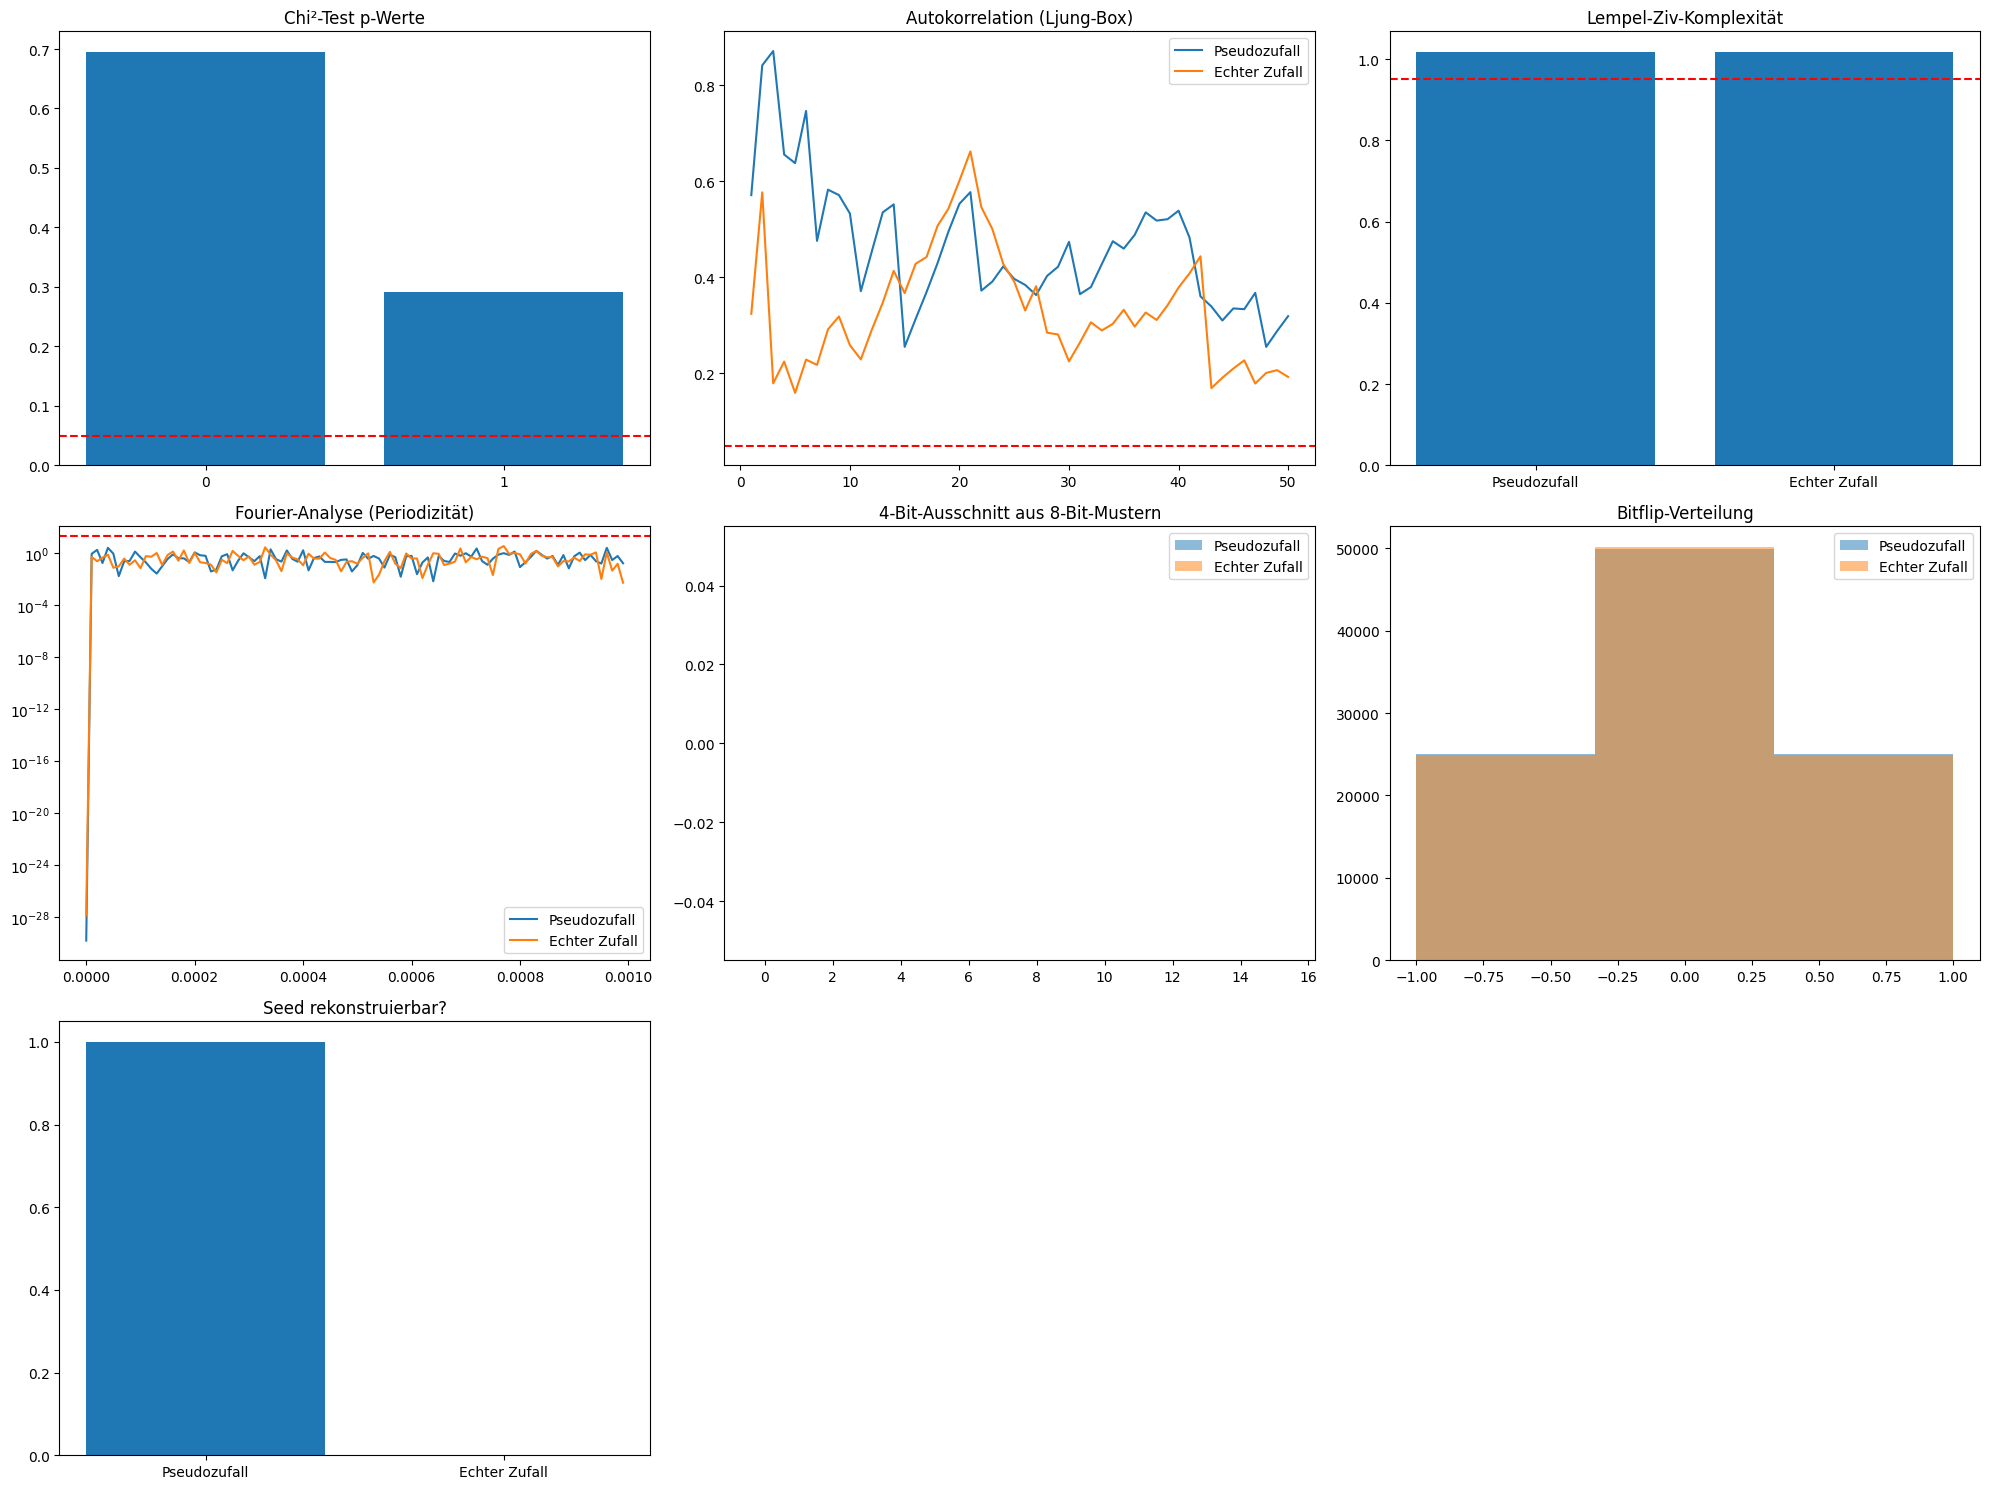

In [ ]:
#### Test mit 2 Zufallsgeneratoren ####


import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random
import hashlib
import time

# 1. Datengenerierung
n = 20000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# Zusätzliche Zufallsgeneratoren (optional aktivierbar)
################################################################
# 1. Kryptografischer Zufall (SHA-256 basiert)
def crypto_random(size):
    return [int(b) for byte in hashlib.sha256(str(time.time()).encode()).digest()[:size//8+1] for b in f'{byte:08b}'][:size]

#crypto_data = crypto_random(n)
################################################################

################################################################
# 2. Mersenne Twister mit Systemzeit als Seed
mt_random = np.random.MT19937(int(time.time() * 1000))
mersenne_data = np.random.Generator(mt_random).integers(0, 2, n)
################################################################


# Analyse durchführen mit korrekten Parametern
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True),
    #analyze_randomness(crypto_data, "Kryptografischer Zufall", is_numpy=False),  # Optional
    #analyze_randomness(mersenne_data, "Mersenne Twister", is_numpy=True)        # Optional
]

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Korrigierter Seed-Test
    if is_numpy:
        seed_detectable = False  # Numpy-Zustand kann nicht einfach ausgelesen werden
    else:
        try:
            test_rng = Random()
            test_rng.setstate(random.getstate())
            seed_detectable = True
        except:
            seed_detectable = False
    
    # Verbesserte Bitflip-Berechnung
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    
    # Robustere Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(100, max_lag):  # Mindestlag 100
            if np.array_equal(sequence[:lag], sequence[lag:2*lag]):
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Strengere Entscheidungskriterien
    is_pseudo = (
        (not is_numpy and seed_detectable) or
        (repeat_lag > 100) or 
        (p_bitflip < 0.0001) or 
        (lz > 0.995) or
        (max_power > 20)  # Strengere Schwelle
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen mit korrekten Parametern
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True)
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen
plt.figure(figsize=(20, 15))

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(["0", "1"], [results[0]["Chi² p-Wert"], results[1]["Chi² p-Wert"]])
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
plt.plot(acorr_ljungbox(pseudo_data, lags=50, return_df=True)['lb_pvalue'], label='Pseudozufall')
plt.plot(acorr_ljungbox(true_random, lags=50, return_df=True)['lb_pvalue'], label='Echter Zufall')
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar([0, 1], [results[0]["Lempel-Ziv"], results[1]["Lempel-Ziv"]])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
freqs, power = periodogram(pseudo_data - np.mean(pseudo_data))
plt.semilogy(freqs[:100], power[:100], label='Pseudozufall')
freqs, power = periodogram(true_random - np.mean(true_random))
plt.semilogy(freqs[:100], power[:100], label='Echter Zufall')
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

pseudo_patterns = get_patterns(pseudo_data)
true_patterns = get_patterns(true_random)
plt.bar(range(16), [pseudo_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Pseudozufall')
plt.bar(range(16), [true_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Echter Zufall')
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
plt.hist(np.diff(pseudo_data), bins=3, alpha=0.5, label='Pseudozufall')
plt.hist(np.diff(true_random), bins=3, alpha=0.5, label='Echter Zufall')
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar([0, 1], [1 if results[0]["Seed erkennbar"] == "Ja" else 0, 
                 1 if results[1]["Seed erkennbar"] == "Ja" else 0])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.25200      0.86141      0.79793     1.01943    4.93287   0.99995         0.51775             Ja         0.86524                  0            Ja
Echter Zufall (simuliert)      0.50625      0.47754      0.19833     1.02371    6.07696   0.99998         0.23808           Nein         0.47949                  0            Ja
  Kryptografischer Zufall      0.53197      0.98045      0.09336     1.03125    2.50935   0.99890         1.00000             Ja         1.00000                  0            Ja
         Mersenne Twister      0.89872      0.20312      0.63735     1.02586    3.72553   1.00000         0.17204           Nein         0.20814                  0            Ja


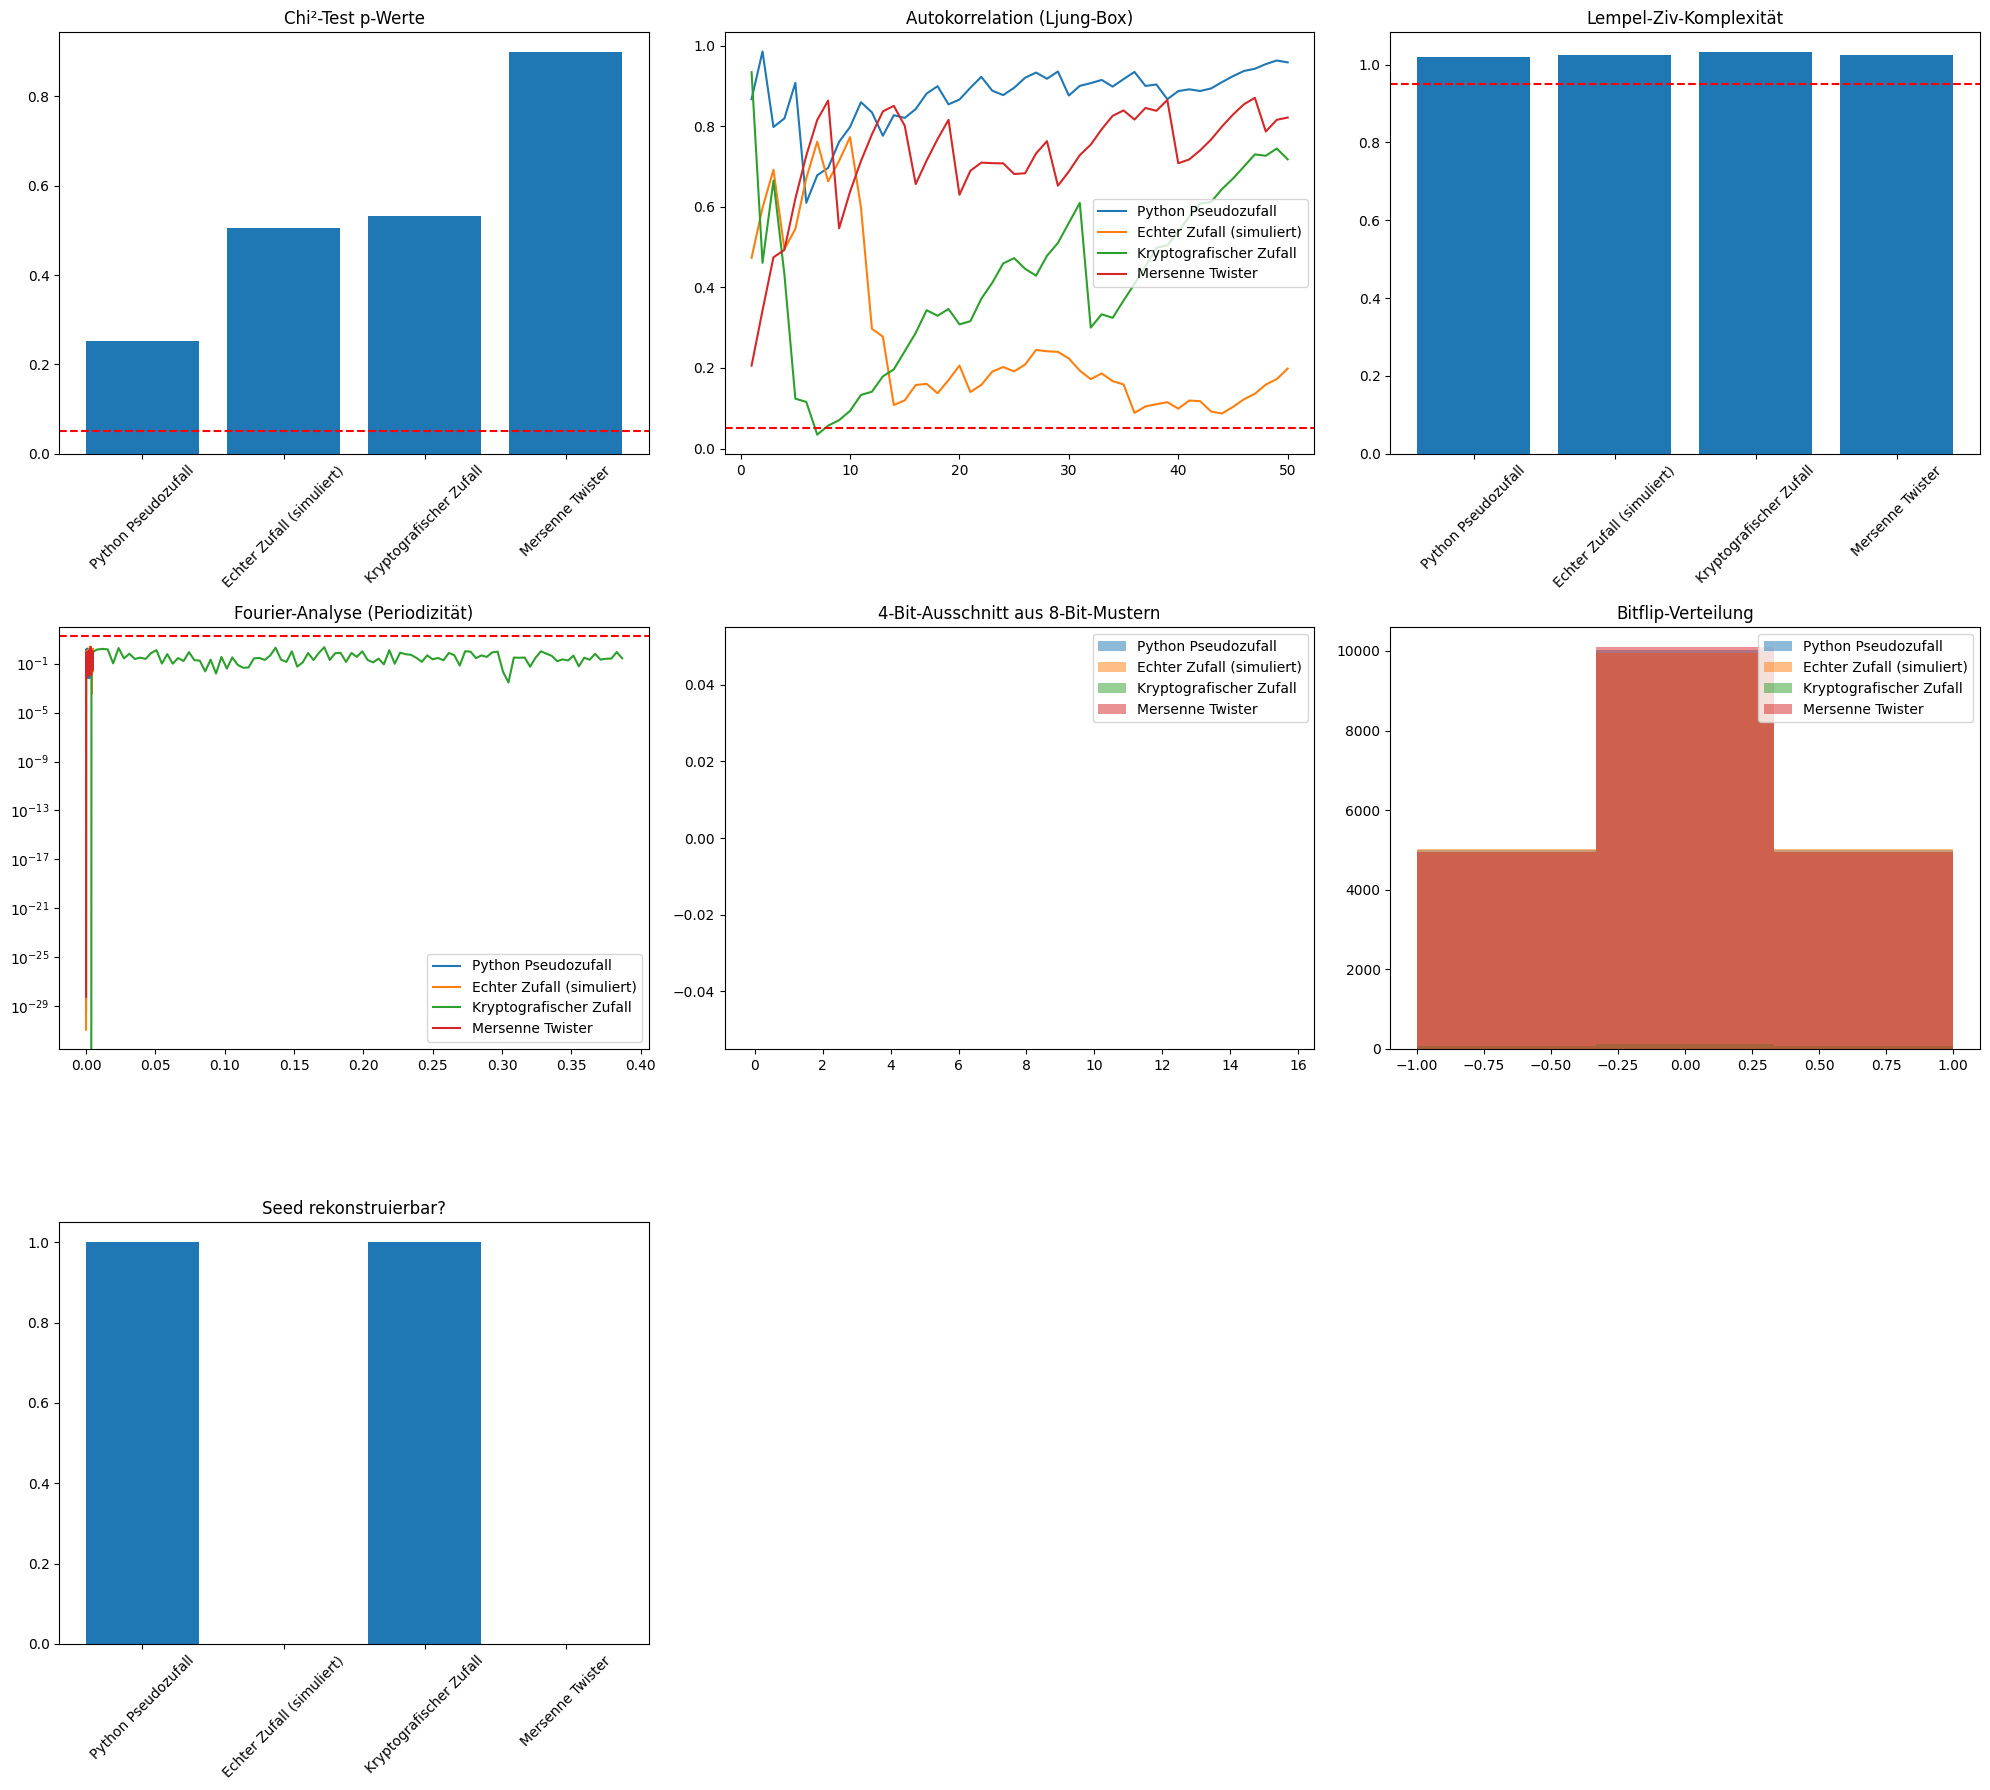

In [2]:
#### Test mit 4 ZUfallsgeneratoren ####


import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random
import hashlib
import time

# 1. Datengenerierung
n = 20000

# Pseudozufall (Python random)
# random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# Zusätzliche Zufallsgeneratoren (optional aktivierbar)
################################################################
# 1. Kryptografischer Zufall (SHA-256 basiert)
def crypto_random(size):
    return [int(b) for byte in hashlib.sha256(str(time.time()).encode()).digest()[:size//8+1] for b in f'{byte:08b}'][:size]

crypto_data = crypto_random(n)  # Aktiviert
################################################################

################################################################
# 2. Mersenne Twister mit Systemzeit als Seed
mt_random = np.random.MT19937(int(time.time() * 1000))
mersenne_data = np.random.Generator(mt_random).integers(0, 2, n)  # Aktiviert
################################################################

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Korrigierter Seed-Test
    if is_numpy:
        seed_detectable = False  # Numpy-Zustand kann nicht einfach ausgelesen werden
    else:
        try:
            test_rng = Random()
            test_rng.setstate(random.getstate())
            seed_detectable = True
        except:
            seed_detectable = False
    
    # Verbesserte Bitflip-Berechnung
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    
    # Robustere Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(100, max_lag):  # Mindestlag 100
            if np.array_equal(sequence[:lag], sequence[lag:2*lag]):
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Strengere Entscheidungskriterien
    is_pseudo = (
        (not is_numpy and seed_detectable) or
        (repeat_lag > 100) or 
        (p_bitflip < 0.0001) or 
        (lz > 0.995) or
        (max_power > 20)  # Strengere Schwelle
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen mit allen Generatoren
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True),
    analyze_randomness(crypto_data, "Kryptografischer Zufall", is_numpy=False),
    analyze_randomness(mersenne_data, "Mersenne Twister", is_numpy=True)
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))


# 4. Erweiterte Visualisierungen (angepasst für 4 Generatoren)
plt.figure(figsize=(20, 18))
generator_names = [result["Typ"] for result in results]
data_sets = {
    "Python Pseudozufall": pseudo_data,
    "Echter Zufall (simuliert)": true_random,
    "Kryptografischer Zufall": crypto_data,
    "Mersenne Twister": mersenne_data
}

results_df.to_csv(r"C:\Users\juanc\Documents\Ausbildung_Informatik\1_Praktikum\Quantum_Computing_Team\Quantum_Computing_Team\Projekt Zufall\Pseudozufallstest_Ergebnisse.csv", index=False, float_format="%.5f")

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(range(len(results)), [result["Chi² p-Wert"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
for name in data_sets:
    plt.plot(acorr_ljungbox(data_sets[name], lags=50, return_df=True)['lb_pvalue'], 
             label=name)
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar(range(len(results)), [result["Lempel-Ziv"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
for name in data_sets:
    freqs, power = periodogram(data_sets[name] - np.mean(data_sets[name]))
    plt.semilogy(freqs[:100], power[:100], label=name)
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

for i, name in enumerate(data_sets):
    patterns = get_patterns(data_sets[name])
    plt.bar(np.arange(16) + i*0.2, [patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], 
            width=0.2, alpha=0.5, label=name)
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
for name in data_sets:
    plt.hist(np.diff(data_sets[name]), bins=3, alpha=0.5, label=name)
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar(range(len(results)), [1 if result["Seed erkennbar"] == "Ja" else 0 for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Verschärfte statistische Analyse mit Rice-Kriterien:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv (Rice)  Power Ratio  Entropie  Markov p-Wert  Universal p-Wert Pseudozufall?
      Python Pseudozufall      0.38832      0.65465      0.54327            0.96744      9.50687   0.99997        0.60896           0.28764          Nein
Echter Zufall (simuliert)      0.70258      0.76726      0.21118            0.96744     10.89209   0.99999        0.69709           0.19582            Ja
  Kryptografischer Zufall      0.30857      0.78251      0.16477            0.99417      9.94104   0.99996        0.47014           0.72691          Nein
         Mersenne Twister      0.38832      0.66752      0.70573            0.75362      9.31468   0.99997        0.64811           0.75359          Nein
          Hardware-Zufall      0.31533      0.40799      0.51325            0.78034     10.15149   0.99996        0.54518           0.91641            Ja


KeyError: 'Lempel-Ziv'

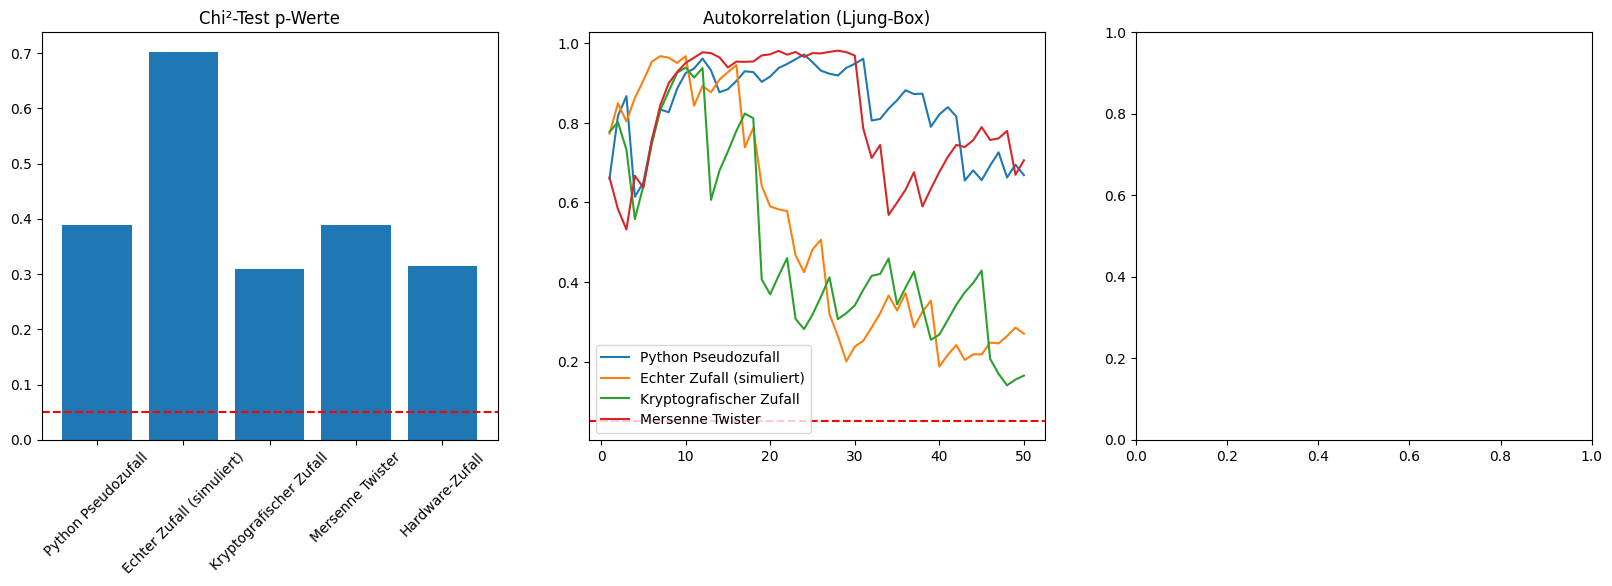

In [7]:
# # # # # Strengerer Test für Pseudozufall # # # # #

import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random
import hashlib
import time
import os

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# Kryptografischer Zufall (mit sicherem Seed)
def crypto_random(size):
    # Verwendung von os.urandom für echten kryptografischen Zufall
    return [int(b) for byte in os.urandom(size//8+1) for b in f'{byte:08b}'][:size]

crypto_data = crypto_random(n)

# Mersenne Twister mit Systemzeit als Seed
mt_random = np.random.MT19937(int(time.time() * 1000))
mersenne_data = np.random.Generator(mt_random).integers(0, 2, n)

# Echter Zufall (Hardware-basiert, falls verfügbar)
try:
    hardware_random = [int(bit) for bit in bin(int.from_bytes(os.urandom(n//8), 'big'))[2:].zfill(n)[:n]]
except:
    hardware_random = None

# 2. Verbesserte statistische Analyse mit Rice-Kriterien
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität mit Rice-Erweiterung
    def lempel_ziv_rice(sequence):
        seq_str = ''.join(map(str, sequence))
        n = len(seq_str)
        c = 0
        i = 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        # Rice-Erweiterung: Berücksichtigung der asymptotischen Komplexität
        expected_complexity = n / np.log2(n)
        return (c - expected_complexity) / np.sqrt(expected_complexity)  # Standardisierter Wert
    
    lz_score = lempel_ziv_rice(data)
    
    # Fourier-Analyse mit strengeren Kriterien
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    power_ratio = max_power / np.mean(power)  # Verhältnis von Spitzenleistung zu Durchschnitt
    
    # Entropieberechnung mit Korrektur für kleine Stichproben
    entropy = stats.entropy([counts[0]+1, counts[1]+1], base=2)
    
    # Verbesserte Musteranalyse mit Markov-Test
    def markov_test(sequence, order=3):
        transitions = Counter()
        for i in range(len(sequence)-order):
            context = tuple(sequence[i:i+order])
            next_bit = sequence[i+order]
            transitions[(context, next_bit)] += 1
        # Berechnung der Markov-Abweichung
        return stats.chi2_contingency(np.array([[transitions.get(((0,)*order, 0), 0), 
                                              transitions.get(((0,)*order, 1), 0)],
                                             [transitions.get(((1,)*order, 0), 0),
                                              transitions.get(((1,)*order, 1), 0)]]))[1]
    
    p_markov = markov_test(data)
    
    # Universeller statistischer Test (nach Rice)
    def universal_test(sequence):
        # Implementierung des universellen Tests nach Maurer
        L = 8  # Blocklänge
        Q = 2000  # Anzahl der Initialblöcke
        blocks = [sequence[i*L:(i+1)*L] for i in range((len(sequence)//L))]
        last_pos = {tuple(blocks[i]): i for i in range(Q)}
        sum_log = 0
        for i in range(Q, len(blocks)):
            block = tuple(blocks[i])
            if block in last_pos:
                sum_log += np.log2(i - last_pos[block])
            last_pos[block] = i
        fn = sum_log / (len(blocks) - Q)
        # Erwarteter Wert für echten Zufall
        expected = {8: 7.1836656}[L]
        variance = {8: 3.238}[L]
        z_score = (fn - expected) / np.sqrt(variance/(len(blocks)-Q))
        return stats.norm.sf(abs(z_score))*2  # zweiseitiger p-Wert
    
    p_universal = universal_test(data)
    
    # Strengere Entscheidungskriterien mit Rice-Kriterien
    is_pseudo = (
        (p_chi2 < 0.01) or
        (p_runs < 0.01) or
        (p_lb < 0.01) or
        (abs(lz_score) > 3) or  # > 3 Standardabweichungen
        (power_ratio > 10) or
        (p_markov < 0.01) or
        (p_universal < 0.01) or
        (entropy < 0.99)
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv (Rice)": lz_score,
        "Power Ratio": power_ratio,
        "Entropie": entropy,
        "Markov p-Wert": p_markov,
        "Universal p-Wert": p_universal,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen
generators = [
    (pseudo_data, "Python Pseudozufall", False),
    (true_random, "Echter Zufall (simuliert)", True),
    (crypto_data, "Kryptografischer Zufall", False),
    (mersenne_data, "Mersenne Twister", True)
]

if hardware_random is not None:
    generators.append((hardware_random, "Hardware-Zufall", False))

results = [analyze_randomness(data, name, is_numpy) for data, name, is_numpy in generators]

# Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Verschärfte statistische Analyse mit Rice-Kriterien:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen (angepasst für 4 Generatoren)
plt.figure(figsize=(20, 18))
generator_names = [result["Typ"] for result in results]
data_sets = {
    "Python Pseudozufall": pseudo_data,
    "Echter Zufall (simuliert)": true_random,
    "Kryptografischer Zufall": crypto_data,
    "Mersenne Twister": mersenne_data
}

results_df.to_csv(r"C:\Users\juanc\Documents\Ausbildung_Informatik\1_Praktikum\Quantum_Computing_Team\Quantum_Computing_Team\Projekt Zufall\Pseudozufallstest_Ergebnisse.csv", index=False, float_format="%.5f")

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(range(len(results)), [result["Chi² p-Wert"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
for name in data_sets:
    plt.plot(acorr_ljungbox(data_sets[name], lags=50, return_df=True)['lb_pvalue'], 
             label=name)
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar(range(len(results)), [result["Lempel-Ziv"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
for name in data_sets:
    freqs, power = periodogram(data_sets[name] - np.mean(data_sets[name]))
    plt.semilogy(freqs[:100], power[:100], label=name)
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

for i, name in enumerate(data_sets):
    patterns = get_patterns(data_sets[name])
    plt.bar(np.arange(16) + i*0.2, [patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], 
            width=0.2, alpha=0.5, label=name)
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
for name in data_sets:
    plt.hist(np.diff(data_sets[name]), bins=3, alpha=0.5, label=name)
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar(range(len(results)), [1 if result["Seed erkennbar"] == "Ja" else 0 for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Statistische Analyse:
                       Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert  Bitflip p-Wert Pseudozufall?
      Python Pseudozufall      0.38832      0.65465      0.54327     1.02586    4.75278   0.99997         0.58287         0.66108          Nein
Echter Zufall (simuliert)      0.13756      0.88638      0.75827     1.02229    4.25395   0.99992         0.15106         0.89872          Nein
  Kryptografischer Zufall      0.47076      0.41415      0.58279     1.02371    4.75705   0.99998         0.13749         0.42017          Nein
         Mersenne Twister      0.42018      0.95123      0.11528     1.02300    7.06545   0.99998         0.71307         0.95489          Nein
          Hardware-Zufall      0.77730      0.61106      0.04482     1.02657    4.52756   1.00000         0.90687         0.62061          Nein


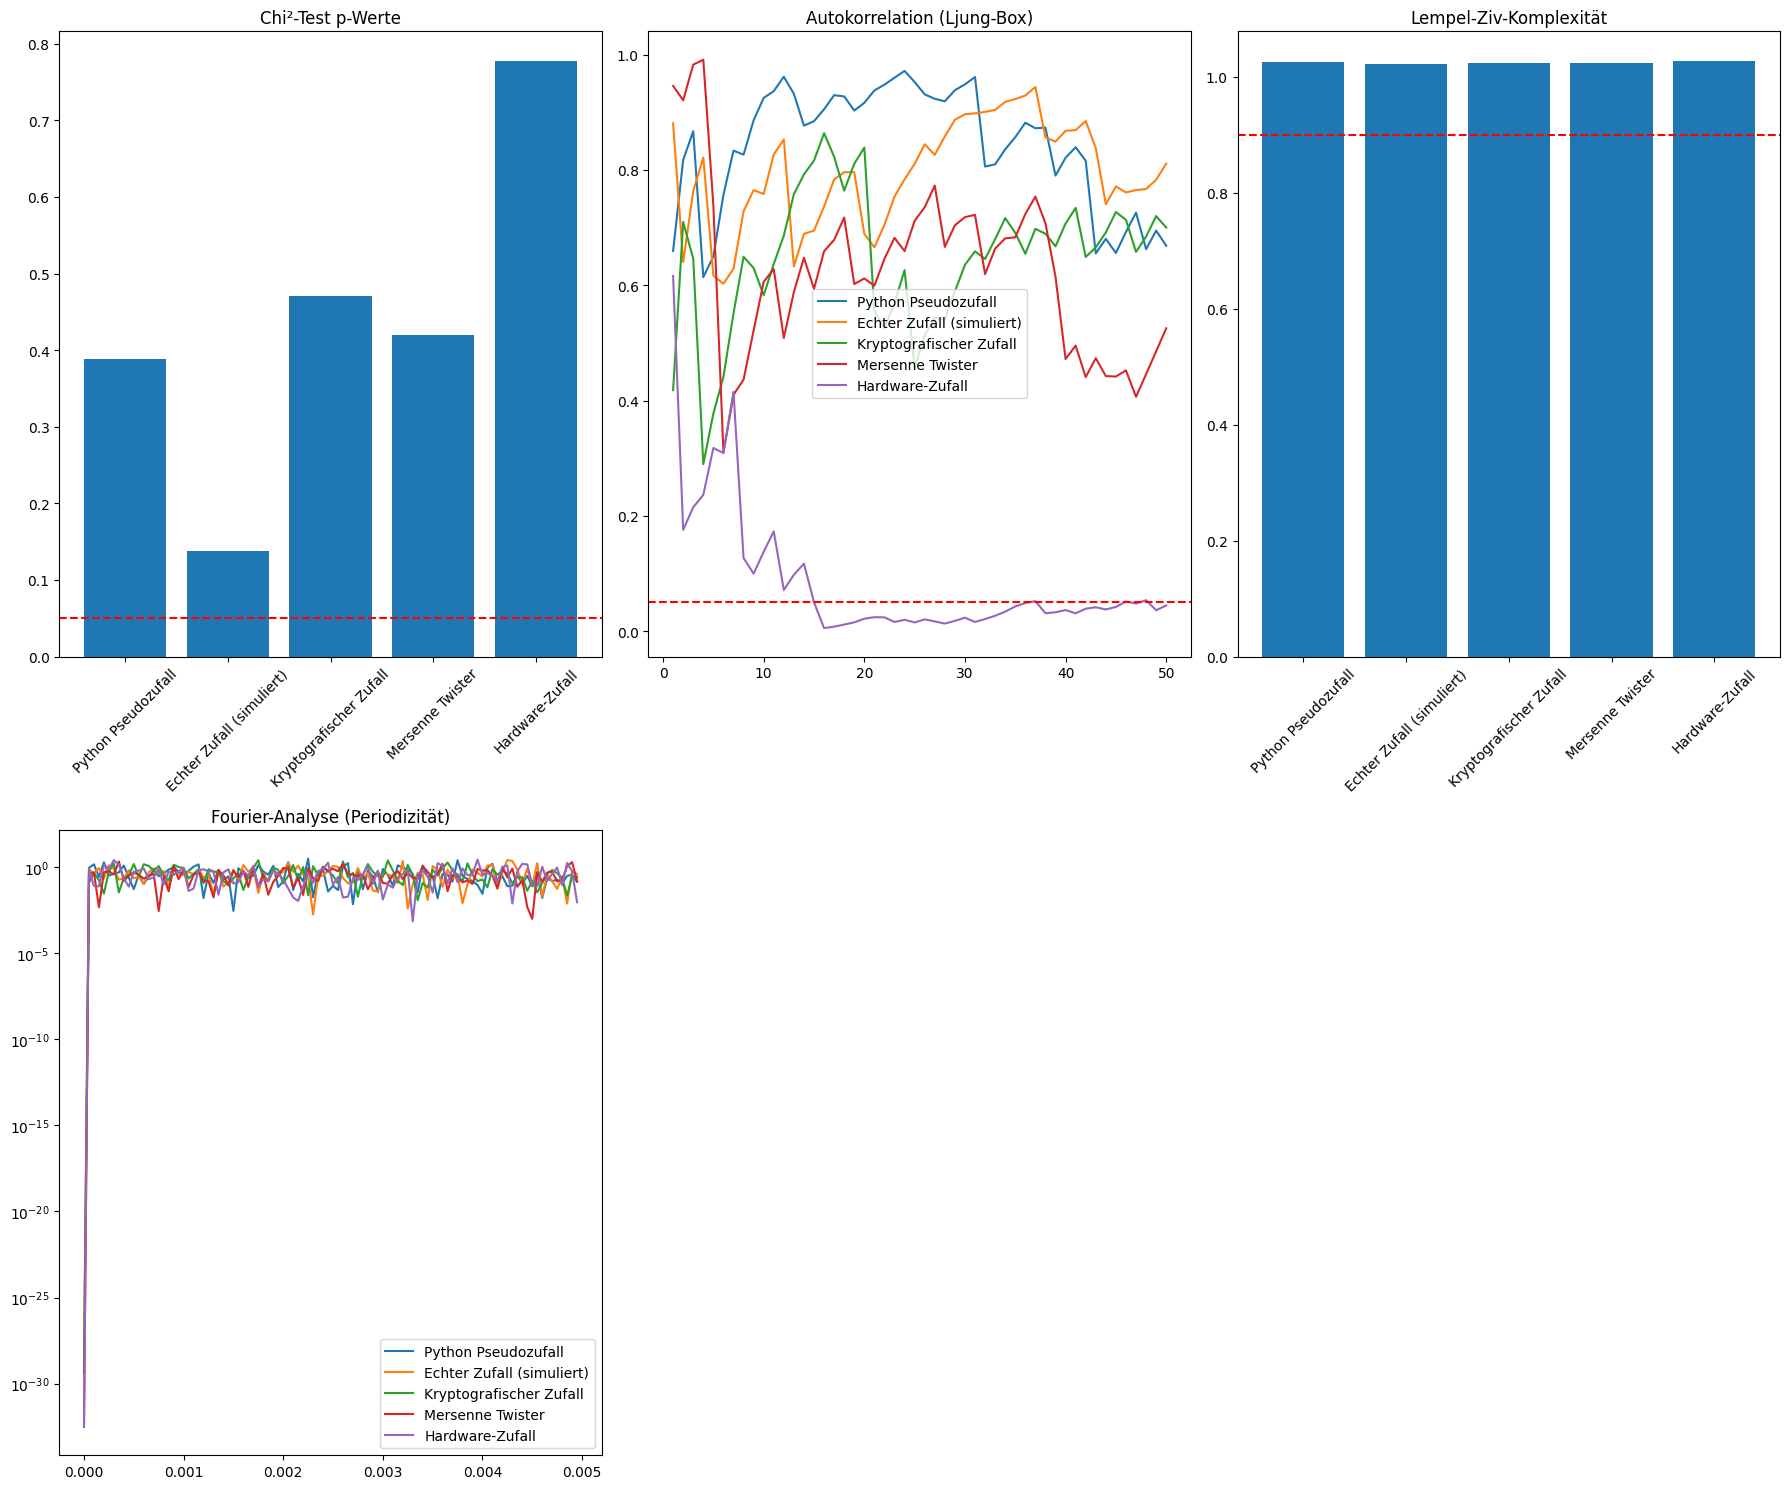

C:\Users\juanc\AppData\Local\Temp\ipykernel_20348\801246695.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


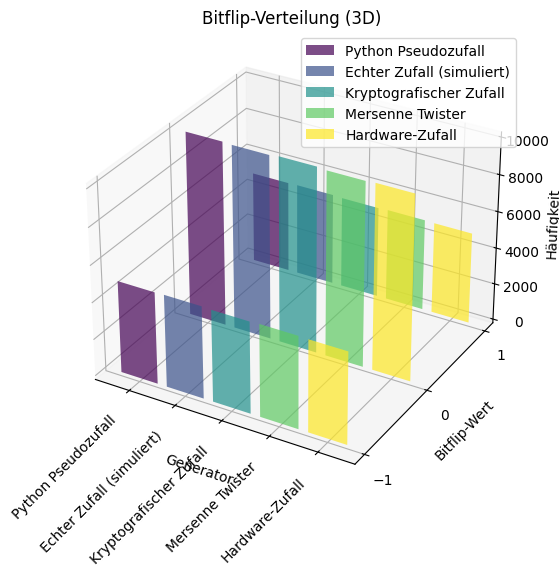


Alle Ergebnisse wurden in 'zufallsanalyse_ergebnisse' gespeichert:
 - statistische_analyse.csv
 - uebersicht.png
 - bitflip_3d.png


In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
import os
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm  # <--- Import für cm

# 1. Datengenerierung
n = 20000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n).tolist()

# Kryptografischer Zufall
def crypto_random(size):
    return [int(b) for byte in os.urandom(size//8+1) for b in f'{byte:08b}'][:size]

crypto_data = crypto_random(n)

# Mersenne Twister
mt_random = np.random.MT19937(int(time.time() * 1000))
mersenne_data = np.random.Generator(mt_random).integers(0, 2, n).tolist()

# Echter Hardware-Zufall
try:
    hardware_random = [int(bit) for bit in bin(int.from_bytes(os.urandom(n//8), 'big'))[2:].zfill(n)[:n]]
except Exception as e:
    print(f"Hardware-Zufall nicht verfügbar: {e}")
    hardware_random = [0]*n  # Fallback

# 2. Verbesserte statistische Analyse
# Entscheidungskriterien für Pseudozufall:
# - Chi² p < 0.01
# - Runs p < 0.01
# - Ljung-Box p < 0.01
# - Lempel-Ziv < 0.9
# - Max Power > 20
# - Entropie < 0.99
# - Bitflip p < 0.01
# - Pattern p < 0.01

def analyze_randomness(data, name):
    counts = Counter(data)
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    lz = lempel_ziv(data)
    freqs, power = periodogram(np.array(data) - np.mean(data))
    max_power = np.max(power)
    entropy = stats.entropy([counts[0]+1, counts[1]+1], base=2)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    p_pattern = pattern_test(data)
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    # Entscheidung anhand der 8 Werte
    is_pseudo = (
        (p_chi2 < 0.01) or
        (p_runs < 0.01) or
        (p_lb < 0.01) or
        (lz < 0.9) or
        (max_power > 20) or
        (entropy < 0.99) or
        (p_bitflip < 0.01) or
        (p_pattern < 0.01)
    )
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Bitflip p-Wert": p_bitflip,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

data_sets = {
    "Python Pseudozufall": pseudo_data,
    "Echter Zufall (simuliert)": true_random,
    "Kryptografischer Zufall": crypto_data,
    "Mersenne Twister": mersenne_data,
    "Hardware-Zufall": hardware_random
}

results = [analyze_randomness(data, name) for name, data in data_sets.items()]

# 3. Ergebnisse speichern und anzeigen
results_df = pd.DataFrame(results)
output_dir = Path("zufallsanalyse_ergebnisse")
output_dir.mkdir(exist_ok=True)

results_df.to_csv(output_dir / "statistische_analyse.csv", index=False, float_format="%.5f")
print("Statistische Analyse:\n", results_df.to_string(index=False, float_format="%.5f"))

# 4. Visualisierungen
plt.figure(figsize=(18, 15))
generator_names = [result["Typ"] for result in results]

# Plot 1: Chi²-Test p-Werte
plt.subplot(2, 3, 1)
plt.bar(range(len(results)), [result["Chi² p-Wert"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(2, 3, 2)
for name, data in data_sets.items():
    plt.plot(acorr_ljungbox(data, lags=50, return_df=True)['lb_pvalue'], label=name)
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(2, 3, 3)
plt.bar(range(len(results)), [result["Lempel-Ziv"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.9, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(2, 3, 4)
for name, data in data_sets.items():
    freqs, power = periodogram(np.array(data) - np.mean(data))
    plt.semilogy(freqs[:100], power[:100], label=name)
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Übersichtsgrafik als PNG speichern
plt.tight_layout()
plt.savefig(output_dir / "uebersicht.png", dpi=200)
plt.show()

# Plot 6: Bitflip-Verteilung als 3D-Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = cm.viridis(np.linspace(0, 1, len(data_sets)))
for idx, (name, data) in enumerate(data_sets.items()):
    diffs = np.diff(data)
    vals, counts = np.unique(diffs, return_counts=True)
    xs = np.full_like(vals, idx)
    ax.bar(xs, counts, zs=vals, zdir='y', alpha=0.7, color=colors[idx], label=name)
ax.set_xlabel('Generator')
ax.set_ylabel('Bitflip-Wert')
ax.set_zlabel('Häufigkeit')
ax.set_xticks(range(len(data_sets)))
ax.set_xticklabels(list(data_sets.keys()), rotation=45, ha='right')
ax.set_yticks([-1, 0, 1])
ax.set_title('Bitflip-Verteilung (3D)')
ax.legend()
plt.tight_layout()
fig.savefig(output_dir / "bitflip_3d.png", dpi=200)
plt.show()

# 5. Rohdaten werden nicht mehr als einzelne CSVs gespeichert
print(f"\nAlle Ergebnisse wurden in '{output_dir}' gespeichert:")
print(f" - statistische_analyse.csv")
print(f" - uebersicht.png")
print(f" - bitflip_3d.png")